# Example: Simplify and Redensify a Watershed

Here we will provide variable lengths for the quads.

In [1]:
# conda package imports
import numpy as np
from matplotlib import pyplot as plt
import logging
import copy
import shapely

import watershed_workflow 
import watershed_workflow.source_list
import watershed_workflow.ui
import watershed_workflow.crs
import watershed_workflow.densification
watershed_workflow.ui.setup_logging(1,None)

%matplotlib ipympl

In [2]:
## Parameters cell -- this provides all parameters that can be changed via pipelining to generate a new watershed. 
coweeta_shapefile = '../../Coweeta_data/input_data/coweeta_basin.shp'
hint = '0601'  # hint: HUC 4 containing this shape.  
               # This is necessary to avoid downloading all HUCs to search for this shape
name = 'Coweeta'

figsize = (6,6)
figsize_3d = (8,6)


In [3]:
# Note that, by default, we tend to work in the DayMet CRS because this allows us to avoid
# reprojecting meteorological forcing datasets.
crs = watershed_workflow.crs.daymet_crs()

## Sources and setup

Next we set up the source watershed and coordinate system and all data sources for our mesh.  We will use the CRS that is included in the shapefile.

A wide range of data sources are available; here we use the defaults except for using NHD Plus for watershed boundaries and hydrography (the default is NHD, which is lower resolution and therefore smaller download sizes).

In [4]:
# set up a dictionary of source objects
sources = watershed_workflow.source_list.get_default_sources()
sources['hydrography'] = watershed_workflow.source_list.hydrography_sources['NHD Plus']
sources['HUC'] = watershed_workflow.source_list.huc_sources['NHD Plus']

watershed_workflow.source_list.log_sources(sources)

2024-11-10 14:46:57,647 - root - INFO: Using sources:
2024-11-10 14:46:57,648 - root - INFO: --------------
2024-11-10 14:46:57,648 - root - INFO: HUC: National Hydrography Dataset Plus High Resolution (NHDPlus HR)
2024-11-10 14:46:57,648 - root - INFO: hydrography: National Hydrography Dataset Plus High Resolution (NHDPlus HR)
2024-11-10 14:46:57,648 - root - INFO: DEM: National Elevation Dataset (NED)
2024-11-10 14:46:57,649 - root - INFO: soil structure: National Resources Conservation Service Soil Survey (NRCS Soils)
2024-11-10 14:46:57,649 - root - INFO: geologic structure: GLHYMPS version 2.0
2024-11-10 14:46:57,649 - root - INFO: land cover: National Land Cover Database (NLCD) Layer: NLCD_2019_Land_Cover_L48
2024-11-10 14:46:57,649 - root - INFO: lai: MODIS
2024-11-10 14:46:57,649 - root - INFO: depth to bedrock: Pelletier DTB
2024-11-10 14:46:57,650 - root - INFO: meteorology: DayMet 1km


### Get HUCs

In [5]:
# load hucs from shape
_, watershed = watershed_workflow.get_split_form_shapes(coweeta_shapefile, out_crs=crs)

2024-11-10 14:46:57,655 - root - INFO: 
2024-11-10 14:46:57,655 - root - INFO: Loading shapes
2024-11-10 14:46:57,656 - root - INFO: ------------------------------
2024-11-10 14:46:57,656 - root - INFO: Loading file: '../../Coweeta_data/input_data/coweeta_basin.shp'
2024-11-10 14:46:57,668 - root - INFO: ... found 1 shapes
2024-11-10 14:46:57,668 - root - INFO: Converting to shapely
2024-11-10 14:46:57,669 - root - INFO:  ... done
2024-11-10 14:46:57,671 - root - INFO: Converting to requested CRS
2024-11-10 14:46:57,679 - root - INFO:  ... done
2024-11-10 14:46:57,679 - root - INFO: Removing holes on 1 polygons
2024-11-10 14:46:57,679 - root - INFO:   -- removed interior
2024-11-10 14:46:57,680 - root - INFO:   -- union
2024-11-10 14:46:57,680 - root - INFO: Parsing 1 components for holes
2024-11-10 14:46:57,680 - root - INFO:   -- complete


### Get Rivers 

In [6]:
# Geomtric parameters tuning the degree of cleaning of the raw data and scales of hydrologic features to be considered
ignore_small_rivers = 2 
prune_by_area_fraction = 0.01 

# download/collect the river network within that shape's bounds
_, reaches = watershed_workflow.get_reaches(sources['hydrography'], hint, 
                                            watershed.exterior(), crs, crs,
                                            in_network=True, properties=True)

rivers = watershed_workflow.construct_rivers(reaches, method='hydroseq',
                                                ignore_small_rivers=ignore_small_rivers,
                                                prune_by_area=prune_by_area_fraction * watershed.exterior().area * 1.e-6,
                                                remove_diversions=True,
                                                remove_braided_divergences=True)




2024-11-10 14:46:57,687 - root - INFO: 
2024-11-10 14:46:57,687 - root - INFO: Loading Hydrography
2024-11-10 14:46:57,688 - root - INFO: ------------------------------
2024-11-10 14:46:57,688 - root - INFO: Loading streams in HUC 0601
2024-11-10 14:46:57,688 - root - INFO:          and/or bounds (1442132.8431974081, -650282.0481837074, 1447117.7928619597, -645090.2638397979)
2024-11-10 14:46:57,689 - root - INFO:   Using Hydrography file "/Users/7s2/Research/watershed_workflow_data/hydrography/NHDPlus_H_0601_GDB/NHDPlus_H_0601.gdb"
2024-11-10 14:46:57,689 - root - INFO:   National Hydrography Dataset Plus High Resolution (NHDPlus HR): opening '/Users/7s2/Research/watershed_workflow_data/hydrography/NHDPlus_H_0601_GDB/NHDPlus_H_0601.gdb' layer 'NHDFlowline' for streams in '(1442132.8431974081, -650282.0481837074, 1447117.7928619597, -645090.2638397979)'
2024-11-10 14:46:58,612 - root - INFO:   Found total of 44 in bounds.
2024-11-10 14:46:58,613 - root - INFO: Filtering reaches not in-

### Simplify

In [7]:
simplify = 70 # length scale to target average edge, ; set this as 1 or 2 when using new densify 
snap_tol = 40
# keeping the originals
rivers_orig=[river.deepcopy() for river in rivers]
watershed_orig=copy.deepcopy(watershed) 

# simplifying 
rivers = watershed_workflow.simplify(watershed, rivers, simplify_hucs=simplify, simplify_rivers=simplify,
                            snap_tol=snap_tol, cut_intersections=True)

# for plotting purpose only
rivers_simplified=[river.deepcopy() for river in rivers] 
watershed_simplified=copy.deepcopy(watershed) 

2024-11-10 14:47:05,946 - root - INFO: 
2024-11-10 14:47:05,947 - root - INFO: Simplifying
2024-11-10 14:47:05,947 - root - INFO: ------------------------------
2024-11-10 14:47:05,947 - root - INFO: Simplifying rivers
2024-11-10 14:47:05,952 - root - INFO: Simplifying HUCs
2024-11-10 14:47:05,953 - root - INFO: Snapping river and HUC (nearly) coincident nodes
2024-11-10 14:47:05,955 - root - INFO:   snapping polygon segment boundaries to river endpoints
2024-11-10 14:47:05,957 - root - INFO:   snapping river endpoints to the polygon
2024-11-10 14:47:05,964 - root - INFO:   cutting at crossings
2024-11-10 14:47:05,965 - root - INFO: intersection found
2024-11-10 14:47:05,967 - root - INFO:   - cutting reach at external boundary of HUCs:
2024-11-10 14:47:05,968 - root - INFO:       split HUC boundary seg into 2 pieces
2024-11-10 14:47:05,968 - root - INFO:       split reach seg into 2 pieces
2024-11-10 14:47:05,972 - root - INFO: Cutting crossings and removing external segments
2024-11-

Plotting original and simplified-pruned rivers and watershed


/Users/7s2/opt/anaconda3/envs/watershed_workflow-pure/lib/python3.10/site-packages/pyproj/crs/crs.py:1282: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)


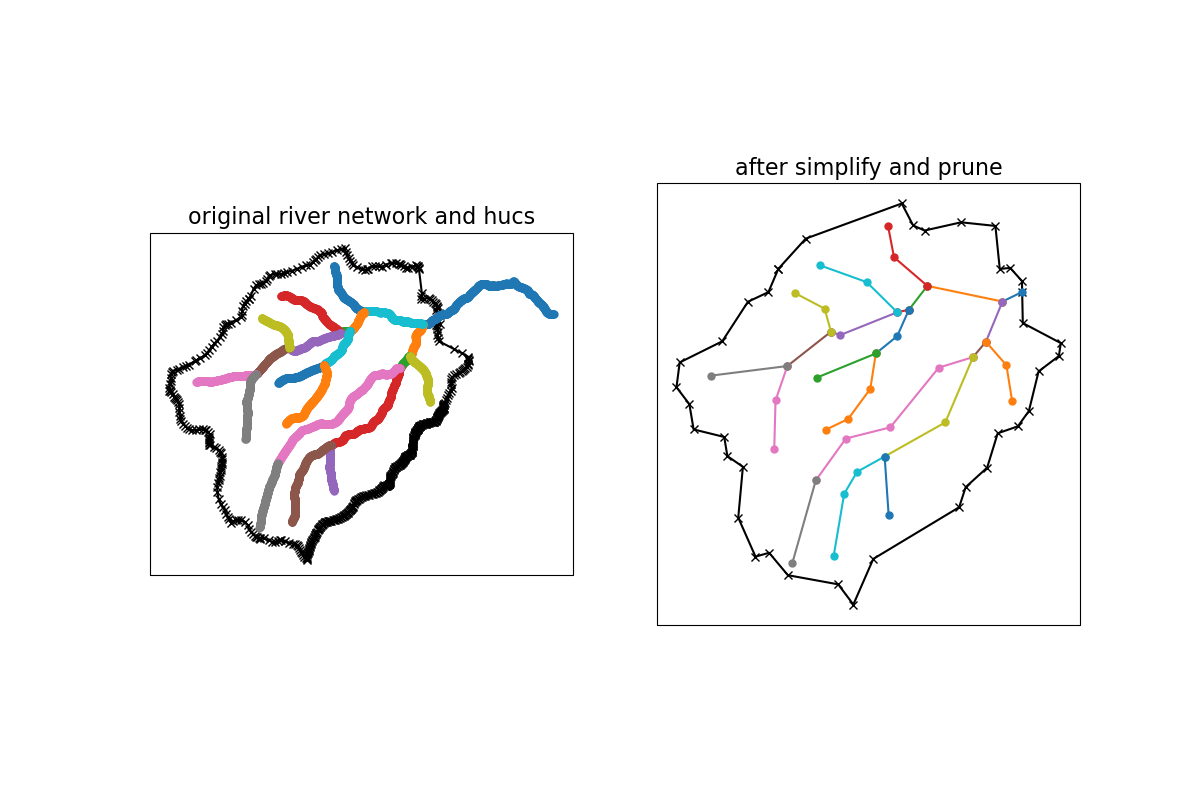

In [8]:
fig, axs = plt.subplots(1,2,subplot_kw={'projection':watershed_workflow.crs.to_cartopy(crs)}, figsize=(12,8))

axs[0].plot(watershed_orig.exterior().exterior.xy[0], watershed_orig.exterior().exterior.xy[1], 'k-x')
axs[0].set_title('original river network and hucs',fontsize=16)
axs[1].plot(watershed.exterior().exterior.xy[0], watershed.exterior().exterior.xy[1], 'k-x')
axs[1].set_title('after simplify and prune',fontsize=16)

for river in rivers_orig:
    for node in river.preOrder():
        x,y=node.segment.xy 
        axs[0].plot(x,y,'-o',markersize=5)

for river in rivers_simplified:
    for node in river.preOrder():
        x,y=node.segment.xy 
        axs[1].plot(x,y,'-o',markersize=5)

### Densification of River Network and Watershed

In [20]:
# how many stream orders we have
stream_orders = []
for river in rivers:
    for node in river.preOrder():
        stream_orders.append(node.properties['StreamOrder'])
    
set(stream_orders)

{1, 2, 3}

In [21]:
target_lens= dict({1:40, 2:55, 3:70}) 

for river in rivers:
    for node in river.preOrder():
        node.properties['target_length'] = target_lens[node.properties['StreamOrder']]

In [9]:
# huc boundary refinement control
refine_d0 = 20
refine_d1 = 100
refine_L0 = 70
refine_L1 = 200

# river densification control
river_limit = 70# try 85, 100

In [22]:
d0 = refine_d0; d1 = refine_d1
L0 = refine_L0; L1 = refine_L1 

# densify_watershed
watershed_workflow.densification.densify_hucs(watershed, watershed_orig, rivers, limit_scales=[d0,L0,d1,L1]) 

#densify_river
watershed_workflow.densification.densify_rivers_new(rivers, limit=True) # note that no original river network is provided here

# treat sharp angles
watershed_workflow.densification.remove_sharp_angles(rivers, watershed, angle_limit=10, junction_angle_limit=10, huc_seg_river_angle_limit=10, limit=river_limit)

2024-11-10 14:50:50,909 - root - INFO:   river min seg length: 38.16983673401464
2024-11-10 14:50:50,909 - root - INFO:   river median seg length: 40.13705363518024


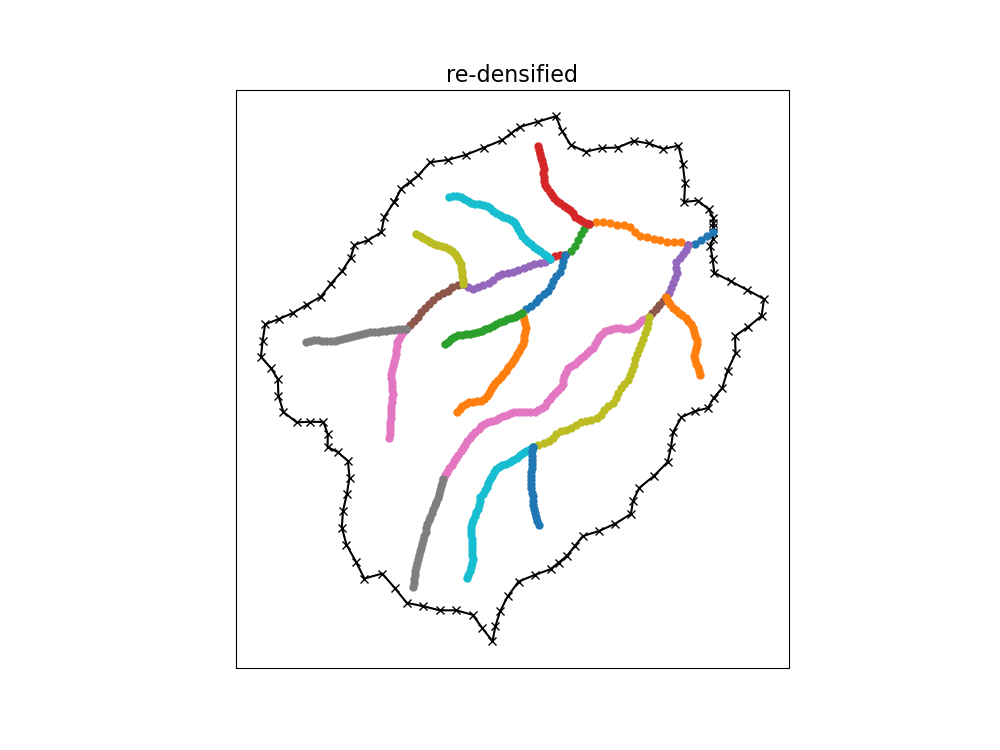

In [25]:
# plot re-densified watershed and river network
fig, ax = plt.subplots(subplot_kw={'projection':watershed_workflow.crs.to_cartopy(crs)}, figsize=(10,7.5))

ax.plot(watershed.exterior().exterior.xy[0], watershed.exterior().exterior.xy[1], 'k-x')
ax.set_title('re-densified',fontsize=16)

for river in rivers:
    for node in river.preOrder():
        x,y=node.segment.xy 
        ax.plot(x,y,'-o',markersize=5)

In [26]:
# plot segment lengths distribution

lens = []
for river in rivers:
    for line in river.depthFirst():
        coords = np.array(line.coords[:])
        dz = np.linalg.norm(coords[1:] - coords[:-1], 2, -1)
        lens = lens + dz.tolist()



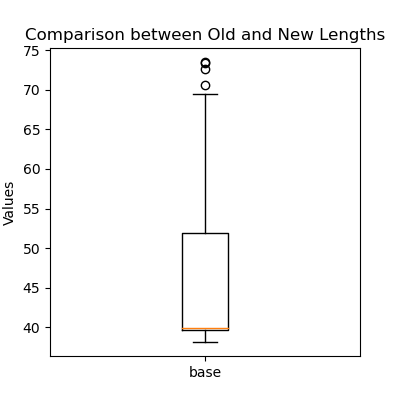

In [27]:
# Assuming lens_new and lens_old are your lists
data = [lens]

labels = ['base']

fig, ax = plt.subplots(figsize=(4,4))
ax.boxplot(data, labels=labels)

ax.set_ylabel('Values')
ax.set_title('Comparison between Old and New Lengths')

plt.show()